### Gộp (Pooling)
- Khi xử lý ảnh, ta thường muốn giảm dần độ phân giải không gian giữa các biểu diễn ẩn, tổng hợp thông tin lại để khi càng đi sâu vào trong, vùng tiếp nhận ở đầu vảo ảnh hưởng đến mỗi nút ẩn càng lớn.
- Nhiệm vụ cuối cùng thường là trả lời một câu hỏi nào đó về toàn bộ tấm ảnh, vậy nên các nút của tầng cuối cùng thường cần phải chịu ảnh hưởng của toàn bộ đầu vào. Bằng cách gộp dần thông tin lại để tạo ra các ánh xạ đặc trung thưa dần, ta sẽ học được một biểu diễn toàn cục, trong khi vẫn có thể giữ nguyên toàn bộ lợi thế đến từ các tầng tích chập xử lý trung gian.
- Hơn nữa, khi phát hiện các đặc trưng cấp thấp như cạnh, ta thường muốn cách biểu diễn này bất biến với phép tịnh tiến trong một chừng mực nào đó. Ví dụ, nếu ta lấy ảnh X với một ranh giới rõ rệt giữa màu đen và màu trăng và dich chuyển toàn bộ tấm ảnh sang trải một điểm ảnh, tức là Z[i, j] = X[i, j + 1] thì đầu ra có thể sẽ khác đi rất nhiều.
- Ta sẽ cần đến các tầng gộp, với hai chức năng là giảm dộ nhạy cảm của các tầng tích chập đối với vị trí và giảm kích thước của các biểu diễn.

#### 1. Gộp cực đại và gộp trung bình
- Giống như các tầng tích chập, các toán tử gộp bao gồm một cửa số có kích thước cố định trượt trên tất cả các vùng đàu vào với giá trị sải bước nhất định, tính toán một giá trị đầu ra duy nhất tại mỗi vị trí mà cửa số trượt qua.
- Tuy nhiên, không giống như phép tương quan chéo giữa đầu vào và hạt nhân, tầng gộp không chứa bộ lọc. Đây có thể là phép tính giá trị cực đại hoặc trung bình trong cửa sổ gộp. Các phép tính này được gọi là __gộp cực đại__ và __gộp trung bình__.

    
    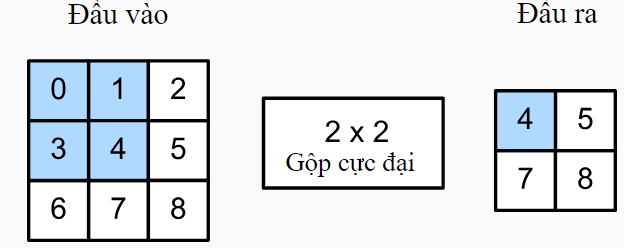



In [18]:
from d2l import mxnet as d2l
from mxnet import np, npx
from mxnet.gluon import nn
npx.set_np()

def pool2d(X, pool_size, mode = 'max'):
    if hasattr(pool_size, '__len__'):
        pool_shape = pool_size
    else:
        pool_shape = (pool_size, pool_size)
    
    Y_shape = (X.shape[0] - pool_shape[0] + 1, X.shape[1] - pool_shape[1] + 1)
    Y = np.zeros(shape = Y_shape)
    
    for i in range(Y_shape[0]):
        for j in range(Y_shape[1]):
            tmp = X[i:i + pool_shape[0], j:j + pool_shape[1]]
            if mode == 'max':
                Y[i][j] = np.max(tmp)
            elif mode == 'avg':
                Y[i][j] = np.mean(tmp)
    return Y



In [19]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2))

array([[4., 5.],
       [7., 8.]])

In [20]:
X = np.array([[0, 1, 2], [3, 4, 5], [6, 7, 8]])
pool2d(X, (2, 2), 'avg')

array([[2., 3.],
       [5., 6.]])

#### 2. Đệm và sải bước
- Giống như các tầng tích chập, các tầng gộp cũng có thể thay đổi kích thước đầu ra, và cũng như trước, ta có thể thay đổi cách thước hoạt động của tầng hộp để đạt được kích thước đầu ra như mong muốn bằng cách thêm đệm vào đầu ra và điều chỉnh sải bước. 
- Ta minh họa bằng cách sử dụng đệm và sải bước trong các tầng gộp cực đại hai chiều MaxPool2D trong module nn của thư viện MXNet Gluon.
- Đầu tiên, ta tạo ra dữ liệu đâu vào kích thước (1, 1, 4, 4) trong đó hai chiều đầu tiên lần lượt là kích thước batch và số kênh.

In [21]:
X = np.arange(16).reshape(1, 1, 4, 4)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]]]])

In [22]:
pool2d = nn.MaxPool2D(pool_size=(3, 3))
pool2d(X)

array([[[[10.]]]])

In [23]:
pool2d = nn.MaxPool2D(pool_size = 3, padding = 1, strides = 2)
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]]]])

#### 3. Với đầu vào đa kênh
- Khi xử lý dữ liệu đầu vào đa kênh, tầng hộp sẽ áp dụng lên từng kênh một cách riêng biệt thay vì cộng từng phần tử tương ứng của các kênh lại với nhau như tầng tích chập. Điều này có nghĩa là số lượng kênh đầu ra của tầng gộp sẽ giống số lượng kênh đầu vào.
- Dưới đây ta sẽ ghép hai mảng X và X + 1 theo chiều kênh để tạo ra đầu vào 2 kênh.

In [24]:
X = np.concatenate((X, X + 1), axis = 1)
X

array([[[[ 0.,  1.,  2.,  3.],
         [ 4.,  5.,  6.,  7.],
         [ 8.,  9., 10., 11.],
         [12., 13., 14., 15.]],

        [[ 1.,  2.,  3.,  4.],
         [ 5.,  6.,  7.,  8.],
         [ 9., 10., 11., 12.],
         [13., 14., 15., 16.]]]])

In [25]:
pool2d = nn.MaxPool2D(3, padding = 1, strides = 2)
pool2d(X)

array([[[[ 5.,  7.],
         [13., 15.]],

        [[ 6.,  8.],
         [14., 16.]]]])